# Depo Notebook

## Abstract

Here's I'll go over some of the functionality of the indexer, redirector, CDN server `depo`.

## Theory

>**TODO:** Add the explanations for choice of encoding scheme and hashing algorithm.

### My Base32 Hashing Algorithm

1. Content if textual is coded into UTF8
2. Once it's just bytes, it's hashed with blake2b in 120-bit digest size or 15 bytes.
3. The hash digest is then fed into the standard `hashlib.hexencode_b32` to convert to the standard hex extension version of b32.
4. Then my custom character-set is translated which is based on the Crockford standard, it just replaces the `=` pad with `U`.
5. Future versions will probably include a single trailing character that encodes padding and versioning.
6. This code should now be 24 characters.
7. To make a shortcode, a minimum code length is selected.
8. Then the shortest code or the minimum code length ordered by creation date `btime` determines the shortest possible code by uniqueness.

### Assigning SHORTCODE_MIN_LEN

In order to limit the amount of time consuming and highly variable code-lengths it's important to determine a schedule of how occupied this database will be by indexed items. Then use the Birthday Problem's approximation equations to determine the likelihood of shortcode collisions at different code lengths based on the number of items currently indexed by a shortcode.




## Implementing Predictions

Here's a step-by-step guide with Python code snippets to set up your notebook.

### Import Necessary Libraries

In [15]:
import math
import pandas as pd
import matplotlib.pyplot as plt

### Define Parameters

Set your initial parameters such as the creation rate and time horizon.

In [16]:
# Parameters
R = 32  # Items created per day
years = 10  # Planning for 10 years
days = years * 365  # Total number of days
safety_factor = 1.2  # 20% safety margin

### Create a Time Series for Item Counts

In [17]:
# Create a DataFrame to hold day-wise data
df = pd.DataFrame({
    'Day': range(1, days + 1)
})

# Calculate cumulative items
df['Cumulative_Items'] = df['Day'] * R

# Apply safety factor
df['Adjusted_Items'] = df['Cumulative_Items'] * safety_factor

### Function to Calculate Minimum Base32 Code Length

In [18]:
def calculate_min_length(N, base=32):
    return math.ceil(math.log(N, base))

### Apply the Function to Determine Code Length Over Time

In [19]:
df['Min_Code_Length'] = (df['Adjusted_Items']
                             .apply(lambda x: calculate_min_length(x)))

In [20]:
df

,Day,Cumulative_Items,Adjusted_Items,Min_Code_Length
0,1,32,38.4,2
1,2,64,76.8,2
2,3,96,115.2,2
3,4,128,153.6,2
4,5,160,192.0,2
...,...,...,...,...
3645,3646,116672,140006.4,4
3646,3647,116704,140044.8,4
3647,3648,116736,140083.2,4
3648,3649,116768,140121.6,4


### Visualize the Required Code Length Over Time

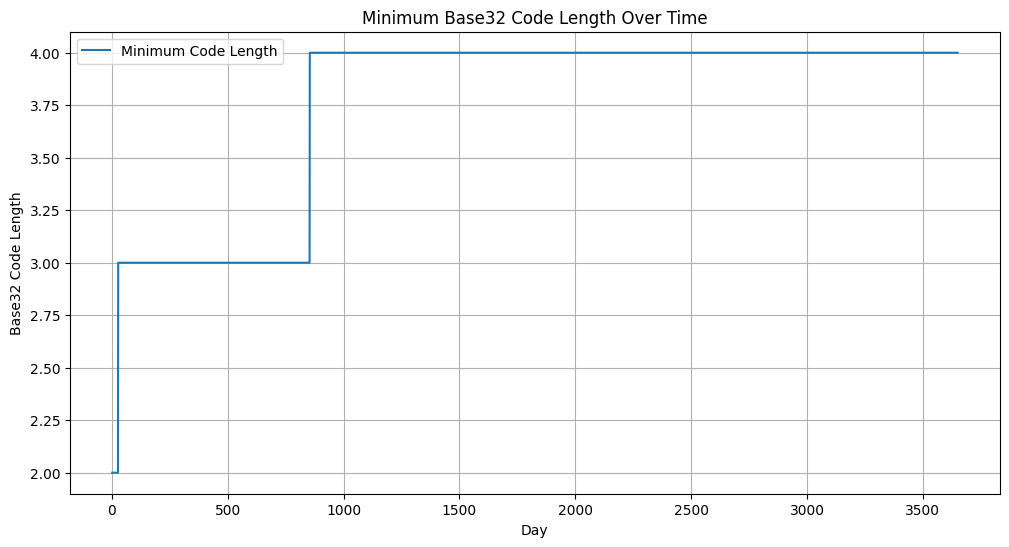

In [21]:
plt.figure(figsize=(12, 6))
plt.plot(df['Day'], df['Min_Code_Length'], label='Minimum Code Length')
plt.xlabel('Day')
plt.ylabel('Base32 Code Length')
plt.title('Minimum Base32 Code Length Over Time')
plt.legend()
plt.grid(True)
plt.show()

### Example Output

The plot will show how the required minimum code length increases over time based on the item creation rate and safety factor. Initially, the code length might be small (e.g., 4 characters), but as N grows, it will increment as needed to maintain uniqueness.
h. Optimizing Code Length Based on Creation Dates

If you want to ensure that shorter codes are used for older items and longer codes are allocated as the dataset grows, you can implement a dynamic system where:

1. Initial Items: Assigned the minimum code length.
2. New Items: If all combinations for the current length are exhausted, use one more base32 digit of the hash.
3. Always store the full hash in the database and query with the start of the code ordered by creation time till a code length results in a unique code

This requires maintaining a database or a registry of used codes and handling collisions appropriately.

## Mathematical Foundation

Previously we took a very basic set of assumptions, let's now map out how much occupancy in the database affects the expected shortcode length. The assumptions we make are on a time series of expected indexed items, for that day, what is the expected shortcode length that is more likely than not to increment the shortcode length?

### Collision Probability Formula

Given:

* S = Total number of unique shortcodes = 32n32n (where nn is the code length)
* N = Number of items (shortcodes generated)

The probability that **at least two items collide** is based on the [Birthday Problem Formula](https://en.wikipedia.org/wiki/Birthday_problem):

$$
P_{collision}=1−\frac{S!}{(S−N)!\cdot{SN}}\approx1−e^{-\frac{N(N−1)}{2S}}
$$

For large $S$ and relatively smaller $N$, this approximation gives you a close approximation:

$$
P_{collision} \approx 1 - \exp(-\frac{N^2}{2S})
$$


### Determining Expected Code Length

Since the most likely code length needed is based on the likelihood of collisions,
the most likely code length is based around whether
you're more likely than not to collide.
That means for every day of this analysis,
the predicted number of indexed items is used to determine the expected code length.
So for any given day you take the previous day's expected code length $N$,
then take the current expected occupancy $S$ and
solve for the case where probability of collision is 50%.

So given:

$$
P_{collision} \le 0.5
$$

Substitute the approximation of the **birthday problem formula** and
realize that $S$ & $N$ are related and that $S = 32^n$ given $n$ is the number of indexed items.

$$
1 - \exp(-\frac{N^2}{2 \cdot 32^n}) \le 0.5
$$

Solve for $n$:

$$
exp(-\frac{N^2}{2 \cdot 32^n}) \ge 0.5
$$
$$
-\frac{N^2}{2 \cdot 32^n} \ge ln(0.5)
$$
$$
\frac{N^2}{2 \cdot 32^n} \le ln(2)
$$
$$
32^n \ge \frac{N^2}{2 \cdot ln(2)}
$$

Now we've rearranged and decomposed the function to a point where $n$ is an exponent.
What's left is to use the logarithmic base change formula to isolate $n$.
Keep in mind, the base in question here is **base 32**.

$$
n \ge \frac{log(\frac{N^2}{2 \cdot ln(2)})}{log(32)}
$$

Thus is our formula to calculate **minimum code length** $n$ required to
keep collision probability *at least as unlikely as not*,
in math terms **below 50%** for a given $N$.

## Implementing the Updated Analysis in a Jupyter Notebook

Given the above determined mathematical derivation for
an expected minimum code length based on indexed items,
let's implement the analysis in code.

### Import Necessary Libraries

In [24]:
import math
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm  # For progress bars

### Define Parameters

Set your initial parameters such as the creation rate, time horizon, and safety factor.

In [26]:
# Parameters
R = 100  # Items created per day
years = 10  # Planning for 10 years
days = years * 365  # Total number of days
safety_factor = 1.2  # 20% safety margin

# Base32 parameters
base = 32
initial_code_length = 4  # Starting with 4 characters

# Collision probability threshold
collision_threshold = 0.5  # 50%

### Create the Time Series DataFrame

Create a DataFrame to hold day-wise data, including cumulative items over time.

In [28]:
# Create a DataFrame to hold day-wise data
df = pd.DataFrame({
    'Day': range(1, days + 1)
})

# Calculate cumulative items
df['Cumulative_Items'] = df['Day'] * R

# Apply safety factor
df['Adjusted_Items'] = df['Cumulative_Items'] * safety_factor

# Optionally, add a Year column
df['Year'] = (df['Day'] / 365).astype(int) + 1

### Function to Calculate Collision Probability

Define a function to calculate the collision probability given NN and nn.

In [29]:
def collision_probability(N, n, base=32):
    S = base ** n
    if S == 0:
        return 1.0  # Avoid division by zero
    # To prevent overflow in exponent for large N and small S
    try:
        exponent = - (N * (N - 1)) / (2 * S)
        if exponent < -700:  # Approximation for very small e^x
            return 1.0
        return 1 - math.exp(exponent)
    except OverflowError:
        return 1.0

#### Explanation:

* The function calculates the collision probability using the approximation.
* It includes error handling to manage scenarios where the exponent becomes too large negative, causing an overflow in the math.exp function.

### Determine Minimum Code Length Over Time

Implement a dynamic system where the code length increases when the collision probability exceeds the threshold.

In [34]:
# Initialize code length
current_code_length = initial_code_length

# Lists to store results
min_code_lengths = []
collision_probs = []

# Iterate through each day
for index, row in tqdm(df.iterrows(), total=df.shape[0]):
    N = row['Adjusted_Items']
    
    # Calculate collision probability with current code length
    P_collision = collision_probability(N, current_code_length, base)
    collision_probs.append(P_collision)
    
    # Check if collision probability exceeds threshold
    if P_collision > collision_threshold:
        current_code_length += 1  # Increment code length
    
    # Append the current code length
    min_code_lengths.append(current_code_length)

# Add results to DataFrame
df['Min_Code_Length'] = min_code_lengths
df['Collision_Probability'] = collision_probs

df.iloc[0::365] # Preview the dataframe with one row per year

100%|█████████████████████████████████████████████████████████████████████████████████████| 3650/3650 [00:00<00:00, 9740.25it/s]


,Day,Cumulative_Items,Adjusted_Items,Year,Min_Code_Length,Collision_Probability
0,1,100,120.0,1,4,0.006786
365,366,36600,43920.0,2,7,0.027679
730,731,73100,87720.0,3,7,0.105931
1095,1096,109600,131520.0,4,7,0.222530
1460,1461,146100,175320.0,5,7,0.360636
1825,1826,182600,219120.0,6,8,0.021597
2190,2191,219100,262920.0,7,8,0.030946
2555,2556,255600,306720.0,8,8,0.041879
2920,2921,292100,350520.0,9,8,0.054340
3285,3286,328600,394320.0,10,8,0.068266


### Visualize the Code Length Growth

Plot how the required code length increases over time based on collision probability.

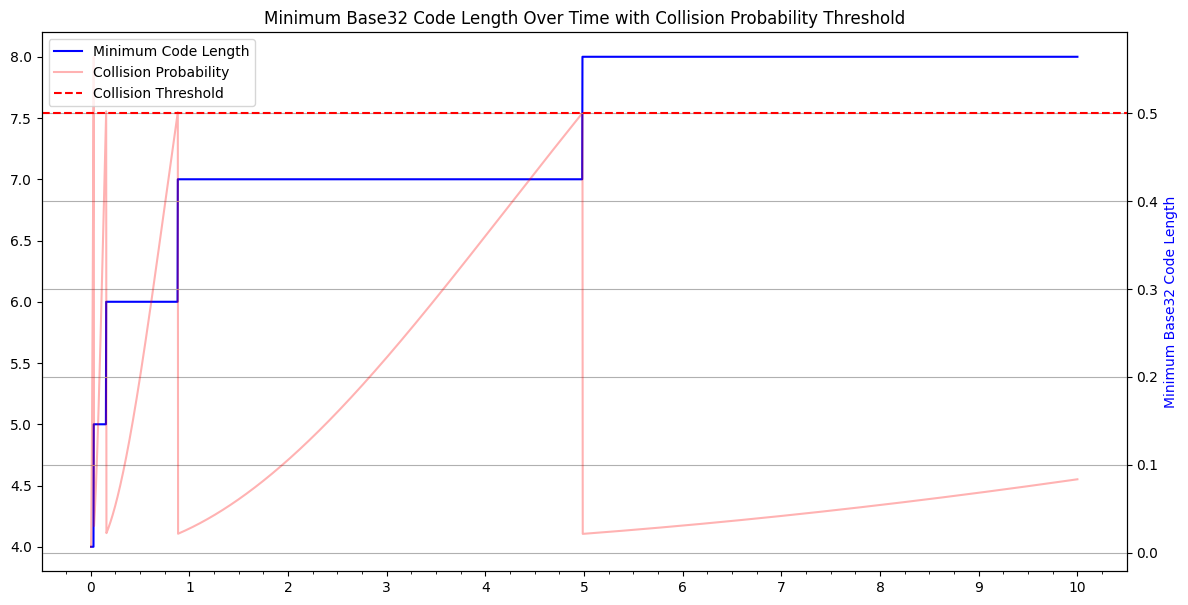

In [51]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
from matplotlib.lines import Line2D

plt.figure(figsize=(14, 7))

# Create fractional years (e.g., quarters)
fractional_year = df['Day'] / 365

# Plot code length over time
line1, = plt.plot(fractional_year, df['Min_Code_Length'], label='Minimum Code Length', color='blue')

# Plot collision probability
ax2 = plt.twinx()  # Create a second y-axis
line2, = ax2.plot(fractional_year, df['Collision_Probability'], label='Collision Probability', color='red', alpha=0.3)
ax2.axhline(y=collision_threshold, color='red', linestyle='--')  # No label to avoid duplication

# Labels and titles
plt.xlabel('Year with Quarters')
plt.ylabel('Minimum Base32 Code Length', color='blue')
plt.title('Minimum Base32 Code Length Over Time with Collision Probability Threshold')

# Set major ticks every 1 year and minor ticks every 0.25 year (quarter)
ax1 = plt.gca()
ax1.xaxis.set_major_locator(MultipleLocator(1))
ax1.xaxis.set_minor_locator(MultipleLocator(0.25))

# Create a custom legend entry for the collision threshold
threshold_line = Line2D([0], [0], color='red', linestyle='--', label='Collision Threshold')

# Combine all legend elements without duplicates
plt.legend([line1, line2, threshold_line], 
           ['Minimum Code Length', 'Collision Probability', 'Collision Threshold'], 
           loc='upper left')

plt.grid(True)

plt.show()
